In [1]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
data_dir = "Data/"

In [5]:
os.makedirs(data_dir, exist_ok=True)

In [6]:
dataset = Planetoid(root=data_dir, name='Cora')

In [7]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
data = dataset[0]

In [9]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [10]:
data.num_nodes

2708

In [11]:
data.num_edges

10556

In [12]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [13]:
edge_index = data.edge_index.numpy()


In [14]:
print(edge_index.shape)

(2, 10556)


In [15]:
edge_example = edge_index[:, np.where(edge_index[0]==466)[0]]


In [16]:
edge_example

array([[ 466,  466,  466,  466,  466],
       [ 970, 1305, 1358, 1738, 2546]], dtype=int64)

In [17]:
node_example = np.unique(edge_example.flatten())

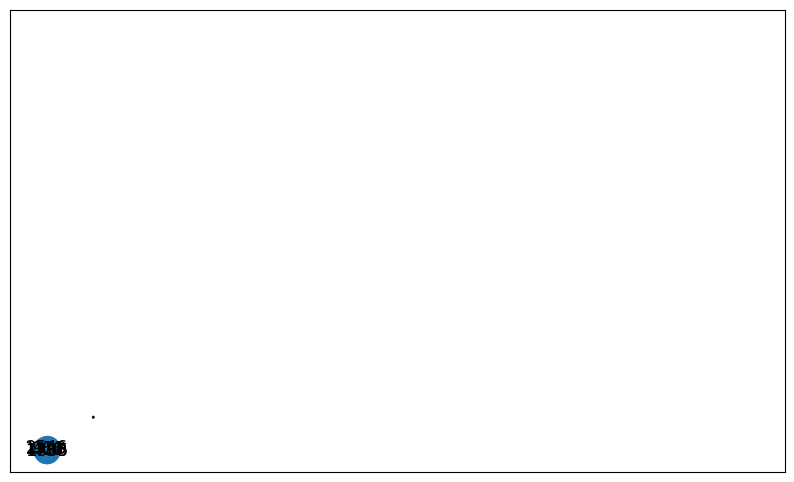

In [18]:
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=True)

In [19]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# Average node degree: 3.90

Average node degree: 3.90


In [21]:
import numpy as np
from gensim.models import Word2Vec
import networkx as nx


class GraphEmbedding:
    """
    A class for computing node embeddings from a graph using random walks and Word2Vec.

    Args:
        graph (networkx.Graph): The input graph.
        p (float): Return parameter p for the node2vec algorithm.
        q (float): In-out parameter q for the node2vec algorithm.
        num_walks (int): Number of random walks to perform per node.
        walk_len (int): Length of each random walk.
        window_size (int): The window size for the Word2Vec model.
        dim (int): The dimensionality of the node embeddings.
        negative (int): Number of negative samples to use for negative sampling.

    Attributes:
        graph (networkx.Graph): The input graph.
        p (float): Return parameter p for the node2vec algorithm.
        q (float): In-out parameter q for the node2vec algorithm.
        num_walks (int): Number of random walks to perform per node.
        walk_len (int): Length of each random walk.
        window_size (int): The window size for the Word2Vec model.
        dim (int): The dimensionality of the node embeddings.
        negative (int): Number of negative samples to use for negative sampling.
        probs (dict): Store transition probabilities.
    """

    def __init__(self, graph, p, q, num_walks, walk_len, window_size, dim, negative):
        self.graph = graph
        self.p = p
        self.q = q
        self.num_walks = num_walks
        self.walk_len = walk_len
        self.window_size = window_size
        self.dim = dim
        self.negative = negative
        self.probs = None  # Store transition probabilities

    def transition_probabilities(self):
        """
        Compute transition probabilities for random walks on the graph.

        Returns:
            dict: A dictionary containing the transition probabilities for each node.
        """
        G = self.graph
        probs = {}

        for source_node in G.nodes():
            probs[source_node] = {"probabilities": {}}
            for current_node in G.neighbors(source_node):
                probs_ = list()
                for destination in G.neighbors(current_node):
                    if source_node == destination:
                        prob_ = G[current_node][destination].get("weight", 1) * (
                            1 / self.p
                        )
                    elif destination in G.neighbors(source_node):
                        prob_ = G[current_node][destination].get("weight", 1)
                    else:
                        prob_ = G[current_node][destination].get("weight", 1) * (
                            1 / self.q
                        )

                    probs_.append(prob_)
                probs[source_node]["probabilities"][current_node] = probs_ / np.sum(
                    probs_
                )

        self.probs = probs  # Store transition probabilities
        return probs
    

    def random_walks(self):
        """
        Generate random walks on the graph.

        Returns:
            list: A list of random walks as sequences of node IDs.
        """
        G = self.graph
        walks = list()
        num_nodes = len(G.nodes())
        S = np.zeros((num_nodes, num_nodes))  # Initialize the similarity matrix


        for start_node in G.nodes():
            for i in range(self.num_walks):
                walk = [start_node]
                walk_options = list(G[start_node])

                if len(walk_options) == 0:
                    break

                first_step = np.random.choice(walk_options)
                walk.append(first_step)

                for k in range(self.walk_len - 2):
                    walk_options = list(G[walk[-1]])

                    if len(walk_options) == 0:
                        break

                    probabilities = self.probs[walk[-2]]["probabilities"][walk[-1]]
                    next_step = np.random.choice(walk_options, p=probabilities)
                    walk.append(next_step)

                walks.append(walk)
                # Update the similarity matrix
                for node_j in G.nodes():
                    if node_j == start_node:
                        S[start_node][node_j] = 1.000  # Probability of visiting itself is 1
                    elif node_j not in walk:
                        S[start_node][node_j] = 0.000  # Probability of not visiting is 0
                    else:
                        # Calculate the probability of visiting node_j during the walk
                        prob_ij = walk.count(node_j) / (self.walk_len - 1)
                        S[start_node][node_j] += prob_ij
        np.random.shuffle(walks)
        walks = [list(map(str, walk)) for walk in walks]

        return walks, S


    def train_embedding(self, walks, dim=None, window_size=None, negative=None):
        """
        Train node embeddings using Word2Vec.

        Args:
            walks (list): List of random walks.
            dim (int, optional): The dimensionality of the node embeddings. If None, use the class's dim.
            window_size (int, optional): The window size for the Word2Vec model. If None, use the class's window_size.
            negative (int, optional): Number of negative samples to use for negative sampling.
                If None, use the class's negative value.

        Returns:
            gensim.models.keyedvectors.KeyedVectors: Trained Word2Vec model.
        """
        if dim is None:
            dim = self.dim
        if window_size is None:
            window_size = self.window_size
        if negative is None:
            negative = self.negative

        model = Word2Vec(
            sentences=walks,
            window=window_size,
            vector_size=dim,
            sg=1,
            negative=negative,
        )
        return model.wv

In [20]:
G = to_networkx(data, to_undirected=True)

In [26]:
embedding = GraphEmbedding(
    G, p=3.5, q=1.5, num_walks=80, walk_len=10, window_size=10, dim=64, negative=10
)

In [27]:
# Compute transition probabilities
probs = embedding.transition_probabilities()

In [28]:
probs

{0: {'probabilities': {633: array([0.17647059, 0.41176471, 0.41176471]),
   1862: array([0.10909091, 0.25454545, 0.25454545, 0.38181818]),
   2582: array([0.14634146, 0.34146341, 0.51219512])}},
 1: {'probabilities': {2: array([0.09677419, 0.22580645, 0.22580645, 0.22580645, 0.22580645]),
   652: array([0.3, 0.7]),
   654: array([1.])}},
 2: {'probabilities': {1: array([0.17647059, 0.41176471, 0.41176471]),
   332: array([0.09677419, 0.22580645, 0.22580645, 0.22580645, 0.22580645]),
   1454: array([1.]),
   1666: array([0.07894737, 0.18421053, 0.18421053, 0.18421053, 0.18421053,
          0.18421053]),
   1986: array([0.00665188, 0.01552106, 0.01552106, 0.01552106, 0.01552106,
          0.01552106, 0.01552106, 0.01552106, 0.01552106, 0.01552106,
          0.01552106, 0.01552106, 0.01552106, 0.01552106, 0.01552106,
          0.01552106, 0.01552106, 0.01552106, 0.01552106, 0.01552106,
          0.01552106, 0.01552106, 0.01552106, 0.01552106, 0.01552106,
          0.01552106, 0.01552106, 

In [29]:
# Generate random walks
walks, S = embedding.random_walks()

In [30]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    #     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

In [31]:
# Train node embeddings using Word2Vec with custom dimensions, window size, and negative sampling
node_embeddings = embedding.train_embedding(walks, dim=64, window_size=10, negative=10)

In [32]:
all_emb = node_embeddings.vectors.T

In [36]:
all_emb.shape

(64, 2708)

In [33]:
los = loss_function(all_emb, S)

In [34]:
los

17286.46970681596

In [ ]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.show()

In [ ]:
print(f"Graph name: {G}")
print("Nodes:", G.nodes())
print("Edges:", G.edges())

In [ ]:
# Find the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

In [ ]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
#                                cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [ ]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# check validation nodes
print("# of nodes to validate on: ", data.val_mask.sum().item())

In [ ]:
print(f'Number of features: {data.num_node_features}')

In [ ]:
print(len(data.x[0]))
data.x[0][:20]

In [ ]:
print(f'Number of edge features: {data.num_edge_features}')
# Number of edge features: 0

In [ ]:
print(f'Number of classes: {dataset.num_classes}')
# Number of classes: 7

In [ ]:
dataset.num_classes

In [ ]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

In [ ]:
G

In [ ]:
data.y[:20]

In [ ]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

In [ ]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [ ]:
label_connection_counts.diagonal().sum() / label_connection_counts.sum()
# 0.8099658961727927

In [ ]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [ ]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

In [ ]:
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask == True)[0]] = 1
split_type_array[np.where(data.val_mask == True)[0]] = 2
split_type_array[np.where(data.test_mask == True)[0]] = 3
split_type_array
plt.scatter(range(2708), split_type_array)
plt.xlabel("index")
plt.show()

In [ ]:
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
# plt.figure(figsize=(10, 6))
    axes[i].bar(range(7), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
plt.show()

In [ ]:
a = {'1': list(np.arange(0.0, 1.0, 0.1))}

In [ ]:
a

In [ ]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

In [ ]:
# Set random seed for reproducibility
import numpy as np

seed_value = 42
np.random.seed(seed_value)

In [ ]:
# # Create a graph
G = nx.karate_club_graph()
# G = nx.Graph()
# G.add_edges_from([(1, 2), (1, 3),(2,3),(1,4),(2,4),(1,5),(4,5),(3,5),(3,8),(3,9),(8,9),(4,6),(4,7),(6,7),(2,10),(5,11)])

In [ ]:
# Define node positions using a spring layout
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=42)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', edge_color='gray', ax=ax)

# Add a title
ax.set_title('Graph with High Structural and Community Similarity')

# Show the plot
plt.axis('off')
plt.show()

In [ ]:
print(f"Graph name: {G}")
print("Nodes:", G.nodes())
print("Edges:", G.edges())

In [ ]:
# Create a mapping from original node IDs to integers starting from 0
node_mapping = {node: idx for idx, node in enumerate(G.nodes())}

# Create a new graph with integer node IDs
G_remapped = nx.relabel_nodes(G, node_mapping)

In [ ]:
G_remapped

In [ ]:
# Define node positions using a spring layout
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=42)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Draw nodes and edges
nx.draw(G_remapped, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', edge_color='gray', ax=ax)

# Add a title
ax.set_title('Graph with High Structural and Community Similarity')

# Show the plot
plt.axis('off')
plt.show()

In [ ]:
# G = nx.karate_club_graph()

# Create a Node2Vec instance with the graph
node2vec = Node2Vec(G_remapped, p=1.0, q=1.0, num_walks=10, walk_length=80)

In [ ]:
degrees = [val for (node, val) in G.degree()]
plt.hist(degrees, bins=range(max(degrees) + 2), alpha=0.7, rwidth=0.85)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution")
plt.show()

In [ ]:
print("Graph name:", G.name)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Nodes:", list(G.nodes()))
print("Edges:", list(G.edges()))

In [ ]:
node2vec = Node2Vec(G, p=1.0, q=1.0, num_walks=10, walk_length=80)


In [ ]:
# Remap node IDs to consecutive integers starting from 0
G_remapped = nx.relabel.convert_node_labels_to_integers(G, first_label=0)

In [ ]:
# Find the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

In [ ]:
import random

In [ ]:
# from node2vec_def.node2vec import Node2Vec

In [ ]:
from node2vec_def.nodevec2 import Node2Vec

In [ ]:
Node2Vec.

In [ ]:
import random

# Define the hyperparameter search space
param_space = {
    'dimensions': [2,4, 8, 16],              # Embedding dimensions
    'walk_length': [5, 6,7,8],            # Length of each random walk
    'num_walks': [4, 5,7, 8],              # Number of random walks per node
    'p': [0.5,1.0, 1.5, 2.0],                   # Return parameter
    'q': [0.5, 1.0,1.5, 2.0],                   # In-out parameter
    'learning_rate': [0.001, 0.01, 0.1],   # Learning rate
    'window_size': [3, 4, 5,6],              # Context window size
    'epochs': [50, 70,100, 125],                 # Number of training epochs
    'negative_samples': [5, 10, 15],       # Number of negative samples
    'batch_size': [4, 8, 16]            # Batch size for training
}


# import random

# # Define the hyperparameter search space
# param_space = {
#     'dimensions': [8,16, 32, 64,128,256],              # Embedding dimensions
#     'walk_length': [30, 60,70,80],            # Length of each random walk
#     'num_walks': list(range(2, 11, 1)),              # Number of random walks per node
#     'p': [0.5,1.0, 1.5, 2.0],                   # Return parameter
#     'q': [0.5, 1.0,1.5, 2.0],                   # In-out parameter
#     'learning_rate': [0.001, 0.01, 0.1],   # Learning rate
#     'window_size': [3, 4, 5,6],              # Context window size
#     'epochs': [3, 4,5, 10],                 # Number of training epochs
#     'negative_samples': [15, 30, 45],       # Number of negative samples
#     'batch_size': [32, 64, 128]            # Batch size for training
# }

In [ ]:
# Perform random search
num_iterations = 10  # Adjust the number of iterations as needed
best_params = None
best_loss = float('inf')

In [ ]:
for _ in range(num_iterations):
    # Randomly sample hyperparameters from the search space
    params = {key: random.choice(values) for key, values in param_space.items()}

    # Calculate the loss using the current hyperparameters
    current_loss = loss_function([params[key] for key in param_space.keys()])

    # Check if the current loss is better than the best so far
    if current_loss < best_loss:
        best_loss = current_loss
        best_params = params

In [ ]:
print("Best Hyperparameters:")
print(best_params)
print("Best Loss:", best_loss)

In [ ]:
# Save the best hyperparameters to a JSON file
with open('best_hyperparameters.json', 'w') as json_file:
    json.dump(best_params, json_file)

In [ ]:
# import json
 
# # Opening JSON file
# f = open('best_hyperparameters.json')
 
# # returns JSON object as
# # a dictionary
# paraaa = json.load(f)
 

In [ ]:
# Load the parameters from the JSON file
with open('best_hyperparameters.json', 'r') as json_file:
    hyperparameters = json.load(json_file)

In [ ]:
# Extract the hyperparameters
dimensions = hyperparameters['dimensions']
walk_length = hyperparameters['walk_length']
num_walks = hyperparameters['num_walks']
p = hyperparameters['p']
q = hyperparameters['q']
learning_rate = hyperparameters['learning_rate']
window_size = hyperparameters['window_size']
epochs = hyperparameters['epochs']
negative_samples = hyperparameters['negative_samples']
batch_size = hyperparameters['batch_size'] 

In [ ]:
dimensions

In [ ]:
# Create and train the Node2Vec model with the loaded hyperparameters
model = Node2Vec(G, dimensions, walk_length, p, q, learning_rate, window_size, epochs, negative_samples)
# graph, dimensions, walk_length,num_walks, p, q, learning_rate, window_size, epochs, negative_sample


In [ ]:
model.preprocess_transition_probs()


In [ ]:
walks = model.simulate_walks(num_walks, walk_length)


In [ ]:
walks

In [ ]:
model.train(walks, batch_size)

In [ ]:
G

In [ ]:
# Example usage:
# Create a NetworkX graph and use Node2Vec
# G = nx.Graph()  # Create your graph
node2vec = NodeVec2(G, p=1.0, q=1.0, num_walks=10, walk_length=80)


In [ ]:
walks = node2vec.simulate_walks()

In [ ]:
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from hyperopt import fmin, tpe, hp
from scipy.optimize import minimize

In [ ]:
# # Define Node2Vec parameters
# dimensions = 128
# walk_length = 80
# num_walks = 10
# p = 1.0
# q = 2.0
# learning_rate = 0.01
# window_size = 10
# epochs = 1
# negative_samples = 5

# dimensions = 2
# walk_length = 5
# num_walks = 3
# p = 1.0
# q = 2.0
# learning_rate = 0.1
# window_size = 3
# epochs = 10
# negative_samples = 2
# batch_size = 2  # Adjust the batch size as needed
# walks = 33
# negative_samples = 5

dimensions = 2
walk_length = 5
num_walks = 10
p = 1.0
q = 2.0
learning_rate = 0.001
window_size = 5
epochs = 30
negative_samples = 5
batch_size = 8

# walks = 22

In [ ]:
G.nodes()

In [ ]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
    obj_func = np.linalg.norm(diff) ** 2
    return obj_func

In [ ]:
import networkx as nx
import numpy as np
from scipy.optimize import minimize
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [ ]:
# Define your objective function
def loss_function(params):
    dimensions, walk_length, num_walks, p, q, learning_rate, window_size, epochs, negative_samples,batch_size = params

    # Create and train the Node2Vec model
    node2vec_model = Node2Vec(G, int(dimensions), int(walk_length), int(num_walks), p, q, learning_rate, int(window_size), int(epochs), int(negative_samples))
    node2vec_model.train(int(batch_size))
    S = node2vec_model.compute_similarity_matrix()

    # Calculate the objective function value
    embeddings = node2vec_model.get_embeddings()
    Z_transpose = np.transpose(embeddings)
    diff = np.dot(Z_transpose, embeddings) - S
#     loss_func = np.linalg.norm(diff) ** 2
    loss_func = np.linalg.norm(diff)
    return loss_func

In [ ]:
model = Node2Vec(G, dimensions, walk_length, num_walks, p, q, learning_rate, window_size, epochs, negative_samples)


In [ ]:
embeddings_bt = model.get_embeddings()


In [ ]:
embeddings_bt

In [ ]:
model.train(batch_size)

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    pos = nx.spring_layout(G, seed=seed_value)

    # Draw nodes with labels (node numbers)
    node_labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=color,
        cmap="Set1",
    )

    plt.show()

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()

In [ ]:
# data = dataset[0]
data

In [ ]:
from torch_geometric.utils import to_networkx

GG = to_networkx(data, to_undirected=True)

In [ ]:
visualize_graph(G, color=data.y)

In [ ]:
walks = []
for _ in range(num_walks):
    for node in G.nodes():
        walk = model.node2vec_walk(node)
        walks.append(walk)

In [ ]:
walks[0]

In [ ]:
len(walks)

In [ ]:
device = "cpu"

In [ ]:
for walk in walks:
    for i, node in enumerate(walk):
        for j in range(max(0, i - window_size), min(len(walk), i + window_size + 1)):
            if i != j:
                node_i = torch.tensor(walk[i]).to(device)
                node_j = torch.tensor(walk[j]).to(device)

                # Print the values of node_i and node_j for debugging
                print("node_i:", node_i)
                print("node_j:", node_j)

In [ ]:
len(walks)

In [ ]:
embeddings = model.get_embeddings()

In [ ]:
embeddings

In [ ]:
# Get the node embeddings
Z =model.get_embeddings()

In [ ]:
Z

In [ ]:
Z.shape

In [ ]:
# Compute the similarity matrix
S = model.compute_similarity_matrix()

In [ ]:
S.shape

In [ ]:
# 
# Calculate the objective function
obj_value = objective_function(Z, S)


In [ ]:
print("Objective Function Value:", obj_value)

In [ ]:
initial_hyperparameters = {
    'dimensions': 4.0,
    'walk_length': 80.0,
    'num_walks': 4.0,
    'p': 1.0,
    'q': 2.0,
    'learning_rate': 0.1,
    'window_size': 5.0,
    'epochs': 5.0,
    'negative_samples': 10.0,
    'batch_size' : 16
}

In [ ]:
# Initial guess for hyperparameters
initial_guess = list(initial_hyperparameters.values())

In [ ]:
initial_guess

In [ ]:
# Minimize the objective function to find optimal hyperparameters
result = minimize(objective_function, initial_guess, method='Nelder-Mead', options={'disp': True})


In [ ]:
# Extract the best hyperparameters
best_hyperparameters = dict(zip(initial_hyperparameters.keys(), result.x))


In [ ]:
# Print the best hyperparameters and the corresponding objective function value
print("Best Hyperparameters:", best_hyperparameters)
print("Objective Function Value:", result.fun)

## CHecking the code

In [ ]:
G = nx.Graph()
G.add_edges_from([(0,1),(0,5),(1, 2), (1, 3),(2,3),(1,4),(2,4),(1,5),(4,5),(3,5),(3,8),(3,9),(8,9),(4,6),(4,7),(6,7),(2,10),(5,11)])

In [ ]:
G = nx.Graph()
G.add_edges_from([(0,1),(1, 2), (1, 3),(2,3)])

In [ ]:

# Define labels for nodes
labels = {
    0: 3,
    1: 0,
    2: 3,
    3: 1,
    4: 2,
    5: 3,
    6: 2,
    7: 2,
    8: 1,
    9: 1,
    10: 3,
    11: 3
}

In [ ]:
# Define labels for nodes
labels = {
    0: 3,
    1: 1,
    2: 2,
    3: 2,
}

In [ ]:
# Assign labels to nodes
nx.set_node_attributes(G, labels, 'label')

In [ ]:
# Access the label of a specific node, for example, node 1
node_1_label = G.nodes[9]['label']
print(f"Label for node 1: {node_1_label}")
your_seed = 42

In [ ]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    pos = nx.spring_layout(G, seed=your_seed)

    # Draw nodes with labels (node numbers)
    node_labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=color,
        cmap="Set1",
    )

    plt.show()

In [ ]:
def visualize_graph_with_labels(G, labels):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    pos = nx.spring_layout(G, seed=your_seed)

    # Assign unique colors to each label
    label_colors = {label: "#" + ''.join(random.choice('0123456789ABCDEF') for _ in range(6)) for label in set(labels.values())}
        # Draw nodes with labels (node numbers)
    node_labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=15)

    # Map node labels to colors
    node_colors = [label_colors[labels[node]] for node in G.nodes()]

    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=False,
        node_color=node_colors,
        cmap="Set1",
    )

    plt.show()

In [ ]:
visualize_graph_with_labels(G,labels)

In [ ]:
dimensions = 128
walk_length = 80
num_walks = 10
p = 1.5
q = 0.5
learning_rate = 0.001
window_size = 40
epochs = 100
negative_samples = 8
batch_size = 32

In [ ]:
johanna = Node2Vec(G, dimensions, walk_length, num_walks, p, q,
                 learning_rate, window_size, epochs, negative_samples)

In [ ]:
walks = []
for _ in range(num_walks):
    for node in G.nodes():
        walk = johanna.node2vec_walk(node)
        walks.append(walk)

In [ ]:
walks[0]

In [ ]:
from gensim.models import Word2Vec

In [ ]:
# def learn_embeddings(walks, dimensions=128, window_size=5, epochs=10):
#     '''
#     Learn embeddings by optimizing the Skipgram objective using SGD.
    
#     Parameters:
#         walks (list of lists): List of walks or sentences for training the Word2Vec model.
#         dimensions (int): The size of the embedding vectors.
#         window_size (int): The maximum distance between the current and predicted word within a sentence.
#         epochs (int): The number of iterations (epochs) over the dataset.

#     Returns:
#         numpy.ndarray: The embedding matrix.
#     '''
#     # Convert the walks to string format if they are not already
#     walks = [list(map(str, walk)) for walk in walks]

#     # Create a Word2Vec model and train it
#     model = Word2Vec(sentences=walks, vector_size=dimensions, window=window_size, min_count=0, sg=1, compute_loss=True, workers=4, epochs=epochs)

#     # Access the embedding matrix
#     embedding_matrix = model.wv.vectors

#     return embedding_matrix

In [ ]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

def learn_embeddings(walks, dimensions=128, window_size=5,negative=negative_samples, epochs=10):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD and plot the loss values.

    Parameters:
        walks (list of lists): List of walks or sentences for training the Word2Vec model.
        dimensions (int): The size of the embedding vectors.
        window_size (int): The maximum distance between the current and predicted word within a sentence.
        epochs (int): The number of iterations (epochs) over the dataset.

    Returns:
        (numpy.ndarray, list): A tuple containing the embedding matrix and a list of loss values over epochs.
    '''
    # Convert the walks to string format if they are not already
    walks = [list(map(str, walk)) for walk in walks]

    # Create a Word2Vec model and train it
    model = Word2Vec(sentences=walks, vector_size=dimensions, window=window_size,negative=negative_samples, min_count=0, sg=1, compute_loss=True, workers=8, epochs=epochs)

    # Access the embedding matrix
    embedding_matrix = model.wv.vectors

    # Collect loss values over epochs
    loss_values = []
    for epoch in range(epochs):
        loss = model.get_latest_training_loss()
        loss_values.append(loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")

    # Plot the loss values
    plt.plot(range(1, epochs + 1), loss_values, marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return embedding_matrix, loss_values

# Example usage
# embedding_matrix, loss_values = learn_embeddings(walks, dimensions=128, window_size=5, epochs=10)


In [ ]:
# learn_embeddings(walks, dimensions=dimensions, window_size=window_size, epochs=epochs, output_file="embeddings.bin")
embedding_matrix, loss_values = learn_embeddings(walks, dimensions=dimensions,negative=negative_samples, window_size=window_size, epochs=epochs)

In [ ]:
loss_values

In [ ]:
embedding_matrix.shape

In [ ]:
Z = embedding_matrix.T

In [ ]:
S

In [ ]:
S = johanna.compute_similarity_matrix()

In [ ]:
Z.shape

In [ ]:
S.shape

In [ ]:
G.nodes()

In [ ]:
R = np.matmul(Z.T, Z)

In [ ]:
F = R-S

In [ ]:
def loss_function(Z, S):
    """
    Calculate the objective function ||Z^T*Z - S||^2.

    Args:
        Z (numpy.ndarray): The node embeddings as a numpy array.
        S (numpy.ndarray): The similarity matrix.

    Returns:
        float: The value of the objective function.
    """
    Z_transpose = np.transpose(Z)
    diff = np.dot(Z_transpose, Z) - S
#     obj_func = np.linalg.norm(diff) ** 2
    obj_func = np.linalg.norm(diff)
    return obj_func

In [ ]:
F

In [ ]:
ee = F**2

In [ ]:
ee

In [ ]:
LA.norm(ee)

In [ ]:
np.linalg.norm(ee)

In [ ]:
(np.dot(Z.T, Z)- S)**2

In [ ]:
np.linalg.norm(np.dot(Z.T, Z)- S) ** 2

In [ ]:
from numpy import linalg as LA

In [ ]:
R

In [ ]:
los_f = loss_function(Z,S)

In [ ]:
los_f

In [ ]:
def create_networkx_graph(graph):
    """
    Create a NetworkX graph from the adjacency list.

    Returns:
    - graph_nx (networkx.Graph): NetworkX graph object.
    """
    graph_nx = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor, weight in neighbors.items():
            graph_nx.add_edge(node, neighbor, weight=weight)
    return graph_nx

In [ ]:
aa = create_networkx_graph(graph)

In [ ]:
aa

In [ ]:
from node2vec_def.nodevec2 import Node2Vec

In [ ]:
# Sample graph as an adjacency list with edge weights
graph = {
    'A': {'B': 0.5, 'C': 0.8},
    'B': {'A': 0.5, 'C': 0.4, 'D': 0.6},
    'C': {'A': 0.8, 'B': 0.4, 'D': 0.7},
    'D': {'B': 0.6, 'C': 0.7}
}

In [ ]:
# Define node positions using a spring layout
import matplotlib.pyplot as plt
pos = nx.spring_layout(G, seed=42)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=12, font_color='black', font_weight='bold', edge_color='gray', ax=ax)

# Add a title
ax.set_title('Graph with High Structural and Community Similarity')

# Show the plot
plt.axis('off')
plt.show()

In [ ]:
# Parameters for Node2Vec
p = 1.0  # Adjust p and q as needed
q = 1.0

# Create a Node2Vec instance
node2vec = Node2Vec(G, p, q)